## Baseline revert rate for newcomers on desktop

Task: [T259196](https://phabricator.wikimedia.org/T259196)

We are curious to learn the percentage of edits that are reverted on desktop that meeting the following conditions:

- Edits made on desktop web
- Edits made using the visual editor or the wikitext editor
- Edits made by people (read: not bots)
- Edits made by people who are logged out or who have made 0 cumulative edits
- Edits made to a Wikipedia content namespace
- Edits that are reverted within 48 hours of being made

Revert Rate: The proportion of non-bot edits made during a month which were reverted within 48 hours.

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse);library(lubridate) 
})

Notes: 
- Data comes from mediawiki_history table. I reviewed the past two years of data from 2018-07-01 to 2020-07-01.
- The event_user_revision count is the number of revisions made by the event_user including the recorded event itself so there should never be a 0 recorded for this field. I filtered to event_user_revision count =1 to include all first time editors. 

In [4]:
query <- "
SELECT
     to_date(event_timestamp) AS date,
     sum(cast(
            revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800 AND -- 48 hours
            array_contains(revision_tags, 'visualeditor') AS int)) AS num_ve_reverts,
     sum(cast(array_contains(revision_tags, 'visualeditor') AS int)) AS num_ve_edits,
     sum(cast(
            revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800 AND -- Edits that are reverted within 48 hours of being made
            not array_contains(revision_tags, 'visualeditor') AS int)) AS num_wikitext_reverts,
    sum(cast(not array_contains(revision_tags, 'visualeditor') AS int)) AS num_wikitext_edits
FROM wmf.mediawiki_history mh 
LEFT JOIN canonical_data.wikis
    ON
        wiki_db = database_code and
        database_group ==  'wikipedia'
WHERE 
    snapshot = '2020-07'
    AND event_entity = 'revision'
    AND NOT array_contains(revision_tags, 'iOS')
    AND NOT array_contains(revision_tags, 'Android')
    AND NOT array_contains(revision_tags, 'Mobile Web')
    AND page_namespace_is_content_historical = true
    AND (event_user_is_anonymous = true OR event_user_revision_count = 1)  -- logged out user or first edit event
    AND SIZE(event_user_is_bot_by_historical) = 0 -- hasn't been a bot
    AND event_timestamp BETWEEN '2018-07-01' AND '2020-07-01'
GROUP BY to_date(event_timestamp)
"

In [5]:
desktop_revert_rate <- wmf::query_hive(query)

In [6]:
head(desktop_revert_rate)

,date,num_ve_reverts,num_ve_edits,num_wikitext_reverts,num_wikitext_edits
,<chr>,<int>,<int>,<int>,<int>
1,2020-01-01,2428,8950,10444,49085
2,2020-01-02,3394,11763,12779,58376
3,2020-01-03,3174,11695,13798,60352
4,2020-01-04,3067,10993,12546,57461
5,2020-01-05,3214,11345,13200,59839
6,2020-01-06,3876,12627,13744,60262


In [7]:
desktop_revert_rate$date <- as.Date(desktop_revert_rate$date, format = "%Y-%m-%d")

# Overall revert rates for last year

In [8]:
##Calculate overall revert rate for the most recent year
desktop_revert_rate_overall <- desktop_revert_rate %>%
mutate(date = floor_date(date, "month")) %>%
 filter(date >= '2019-07-01' & date <= '2020-07-01')  %>%
  summarise(ve_monthly_revert_rate = sum(num_ve_reverts)/sum(num_ve_edits),
           wikitext_monthly_revert_rate = sum(num_wikitext_reverts)/sum(num_wikitext_edits))
  

desktop_revert_rate_overall


ve_monthly_revert_rate,wikitext_monthly_revert_rate
<dbl>,<dbl>
0.3098156,0.2385581


Visual editor has an average revert rate of 31% and wikitext has an average revert rate of 23.9%. This is similar to the revert rates found 

# Monthly revert rate changes by editing interface

In [20]:
##Calculate monthly revert rate and yoy change
desktop_revert_rate_monthly_yoy <- desktop_revert_rate %>%
mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(ve_monthly_revert_rate = sum(num_ve_reverts)/sum(num_ve_edits),
           wikitext_monthly_revert_rate = sum(num_wikitext_reverts)/sum(num_wikitext_edits)) %>%
  arrange(date) %>%
  mutate(ve_revert_rate_yoy = (ve_monthly_revert_rate/lag(ve_monthly_revert_rate,12) -1),
        wikitext_revert_rate_yoy = (wikitext_monthly_revert_rate/lag(wikitext_monthly_revert_rate,12) -1),
        revert_rate_diff = ve_monthly_revert_rate - wikitext_monthly_revert_rate)

desktop_revert_rate_monthly_yoy


date,ve_monthly_revert_rate,wikitext_monthly_revert_rate,ve_revert_rate_yoy,wikitext_revert_rate_yoy,revert_rate_diff
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-07-01,0.2425703,0.2175273,NA,NA,0.02504295
2018-08-01,0.2467989,0.2190919,NA,NA,0.02770705
2018-09-01,0.3036774,0.2455003,NA,NA,0.05817709
2018-10-01,0.3237705,0.2610159,NA,NA,0.06275454
2018-11-01,0.3263428,0.2627746,NA,NA,0.06356825
2018-12-01,0.3028943,0.2439331,NA,NA,0.05896113
2019-01-01,0.3168558,0.2576286,NA,NA,0.05922724
2019-02-01,0.3197054,0.2627341,NA,NA,0.05697123
2019-03-01,0.3223602,0.2571270,NA,NA,0.06523311


In [10]:
avg_diff = desktop_revert_rate_monthly_yoy %>%
    summarise(avg = mean(diff))
avg_diff

avg
<dbl>
0.06216788


In [11]:
options(repr.plot.width = 10, repr.plot.height = 7)

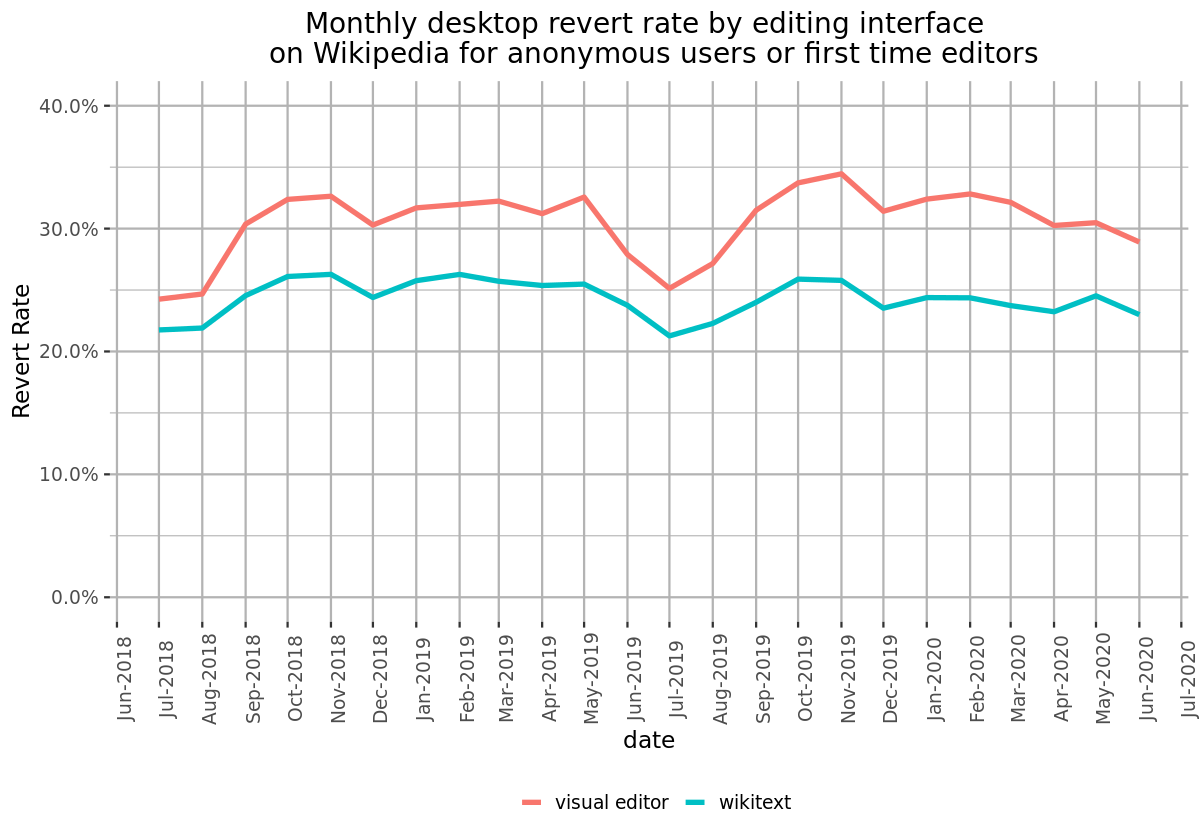

In [19]:
desktop_revert_rate_monthly_ts_plot <- desktop_revert_rate_monthly_yoy %>%
    select(-c(4,5)) %>%  #remove yoy columns
    gather(editing_interface, revert_rate, 2:3) %>%
    ggplot(aes(x= date, y= revert_rate, color = editing_interface)) +
    geom_line(size = 1.5) +
    scale_x_date(date_labels = "%b-%Y", date_breaks = "1 month", minor_breaks = NULL) +
    scale_y_continuous("Revert Rate", labels = scales::percent, limits = c(0, 0.40))  +
  labs( title = "Monthly desktop revert rate by editing interface \n on Wikipedia for anonymous users or first time editors"
  )+
    scale_color_discrete(name = "Editing Interface", labels = c("visual editor", "wikitext")) +
    ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
   theme(plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 90),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))
            
    
desktop_revert_rate_monthly_ts_plot
ggsave("Figures/desktop_revert_rate_monthly_ts_plot.png", desktop_revert_rate_monthly_ts_plot, width = 16, height = 8, units = "in", dpi = 300)

There is a fairly consistent difference in revert rates between the two editing interfaces for the past two years, with the maximum difference around 8%. The average difference in monthly revert rates between the two editing interfaces for the past two years is 6.2%.  Visual Editor has a higher revert rate ranging from 24% to 32% while wikitext's revert rate ranges from about 21% to 26%.

# Review YOY changes by editing interface

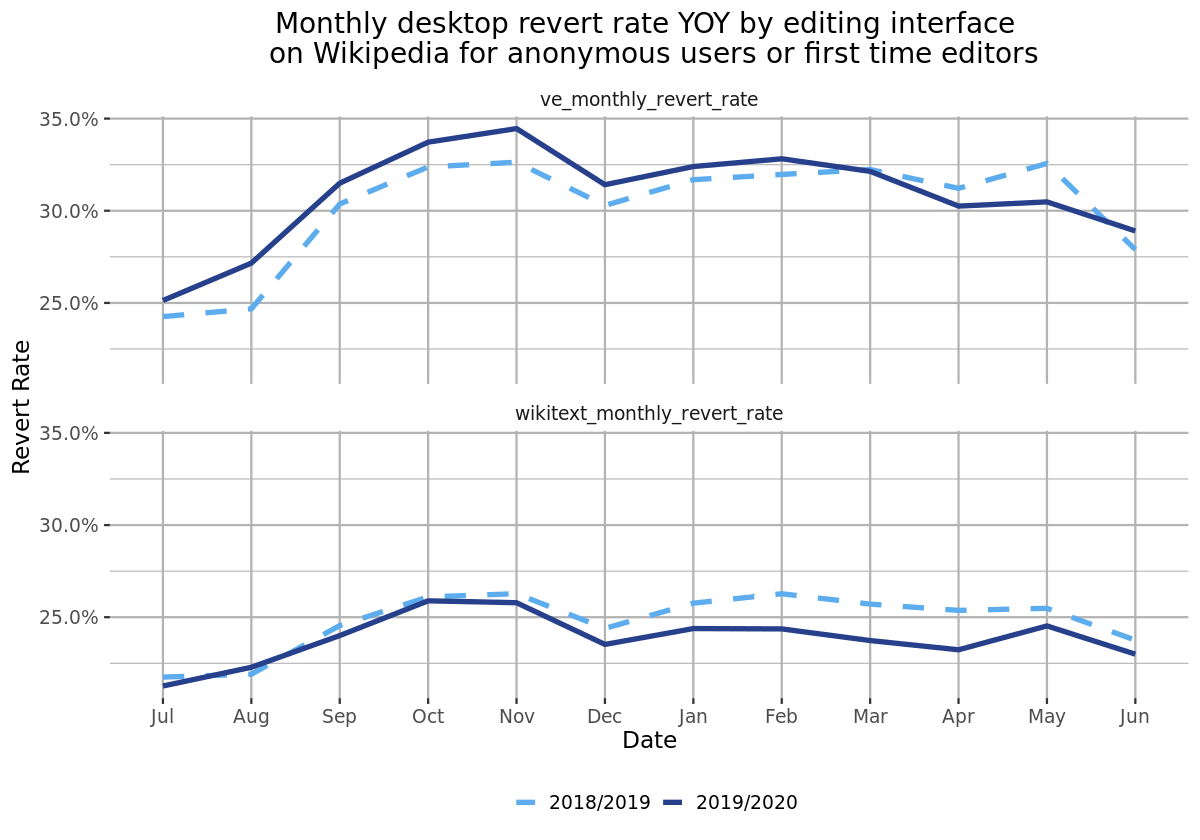

In [16]:
# Plot chart of yoy changes

desktop_revert_rate_monthly_yoy_plot <- desktop_revert_rate_monthly_yoy %>%
    select(-c(4,5)) %>%  #remove yoy columns
    gather(editing_interface, revert_rate, 2:3) %>%
    mutate(year = case_when(date >= '2018-07-01' & date < '2019-07-01' ~ '2018/2019',
                         date >= '2019-07-01' & date < '2020-08-01' ~ '2019/2020'),
         MonthN =as.factor(format(as.Date(date),"%m")),
         CalMonth = months(as.Date(date), abbreviate=TRUE))


desktop_revert_rate_monthly_yoy_plot$MonthN = factor(desktop_revert_rate_monthly_yoy_plot$MonthN, levels=c("07", "08", "09", "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06"))

desktop_revert_rate_monthly_yoy_plot$year = factor(desktop_revert_rate_monthly_yoy_plot$year, levels = c('2018/2019', '2019/2020'))


p <- ggplot(desktop_revert_rate_monthly_yoy_plot, aes(x=MonthN, y = revert_rate, group = year, color = year, linetype = year)) +    
  geom_line(size = 1.5
           ) +
  scale_y_continuous("Revert Rate", labels = scales::percent) +
  scale_x_discrete(breaks = desktop_revert_rate_monthly_yoy_plot$MonthN, labels = desktop_revert_rate_monthly_yoy_plot$CalMonth)+
  labs(title = "Monthly desktop revert rate YOY by editing interface \n on Wikipedia for anonymous users or first time editors") +
        xlab("Date") +
  facet_wrap(~editing_interface, nrow = 2) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_linetype_manual(breaks=c('2018/2019', '2019/2020'), values=c(2,1)) + 
    scale_color_manual(values = c( "steelblue2","royalblue4")) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))


p
ggsave("Figures/desktop_revert_rate_monthly_yoy_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

The VE revert rate has been showing a YoY decline since March 2020. Wikitext has pretty consistently been showing a YoY decleine in revert rate this past year. YoY changes range from about -8% (April 2020 on wikitext) to +10% (August 2019 on Visual Editor).